In [ ]:
# 
# Purpose: clean up raw NPS .xlsx files prior to training, write cleaned output to new .csv file
# Method: 
#   1) For each store... Remove missing values, clean text, remove punctuation, lemmatize
#   2) Use textblob to calculate sentiment scores for NPS and Overall comments
#   3) Add sentiment scores for both the NPS Comment, and Overall Comment.
#   4) Combine all store comments into single aggregated file by district
#
# Author: Eric G. Suchanek, PhD
# (c)2022 BestBuy, all rights reserved
#

In [ ]:
# library imports
import pandas as pd

import re
import nltk

import os

# Bestbuy specifics
import bby
import bby.util as ut

from bby.util import clean_doc, tb_enrich, nps_cleanstring
from bby.util import lemma_remove_stopwords, get_wordnet_pos, nps_lemmatise

import matplotlib.pyplot as plt 


_territory = ut.Our_Territory
_market = ut.Our_Market
_district = ut.Our_District
null_str = "xyxyxz"


In [2]:

# convert 'promoter' 'passive' 'detractor' to numerical index
def nps_to_code(nps_list):
    codelist = []
    for comment in nps_list:
        if (comment =="Promoter"):
            codelist.append('2')
        elif (comment == "Passive"):
            codelist.append('1')
        elif (comment == "Detractor"):
            codelist.append('0')
        else:
            codelist.append('xxx')
    return(codelist)


# write the comments (nps and overall) to files in specific directories based on whether they are
# promoters, passive or detractors
# write the list of comments to a file based on the path, district, and prefix
def write_sentences(sentencelist, storename, _path, district, prefix):
    lc = 1
    outfilename = f'{_path}{district}_{storename}_{prefix}_{lc}{ut._txt_extension}'
    outfile = open(outfilename, 'w')

    for items in sentencelist:
        outfile.writelines(items)
        outfile.write('\n')
        lc += 1
    outfile.close()
    return

def write_comments(district, storelist):
    DEBUG = ut.DEBUG

    if (DEBUG):
        print(storelist)

    for storename in storelist:
        if (DEBUG):
            print(f'....Writing comments for store: {storename}')
        input_filename = f"{ut._cleaned_path}{ut._output_filename_prefix}{storename}_{district}.csv"
        new_df = pd.read_csv(input_filename)

        pos_comments = new_df.loc[new_df['NPS_Code'] == 2]
        pass_comments = new_df.loc[new_df['NPS_Code'] == 1]
        detr_comments = new_df.loc[new_df['NPS_Code'] == 0]

        pos_stringlist = pos_comments['NPSCommentCleaned']
        pass_stringlist = pass_comments['NPSCommentCleaned']
        detr_stringlist = detr_comments['NPSCommentCleaned']
        
        write_sentences(pos_stringlist, storename, ut._prom_words_path, district, "NPSComment")
        write_sentences(pass_stringlist, storename, ut._pass_words_path, district, "NPSComment")
        write_sentences(detr_stringlist, storename, ut._det_words_path, district, "NPSComment")

        pos_stringlist = pos_comments['OverallCommentCleaned']
        pass_stringlist = pass_comments['OverallCommentCleaned']
        detr_stringlist = detr_comments['OverallCommentCleaned']

        write_sentences(pos_stringlist, storename, ut._prom_words_path, district, "OverallComment")
        write_sentences(pass_stringlist, storename, ut._pass_words_path, district, "OverallComment")
        write_sentences(detr_stringlist, storename, ut._det_words_path, district, "OverallComment")
    return

# NPS spreadsheet cleanup and reformatting for natural language processing
# data paths and filename patterns
# Assumes following directory structure
# main directory/
#  - notebook/
#  - data/
#  - raw/
#   -clean/

# Given the district, read the raw .xlsx file, fill null values, and perform the following cleanup:
#  - remove URL, emails, extraneous punctuation
#  - calculate sentiment scores from the blob package
# write a new .csv file with NPS comment, overall comment, confirm number, location, workforce, NPS rating
#


def NPS_cleanup_market(market=_market, district=_district):
    print(f'Processing market: {market}')
    NPS_cleanup_district(market, district)
    return

# will need to change this to work like NPS_cleanup_national since we now use NPS_cleanup_national primarily
# 5/23/22 -egs-
#
def NPS_cleanup_district(market, district):   
    storelist1 = ut.district_stores_dict.get(market)
    storelist = storelist1.get(district)
    _cleaned_path = ut._cleaned_path
    _raw_path = ut._raw_path
    _output_filename_prefix = ut._output_filename_prefix
    _filename_prefix = ut._filename_prefix
    
    # filename for aggregated final file
    cleaned_filename = f"{_cleaned_path}NPS_District_{district}.csv"
    output_filename_list = []

    print(f'..Processing District: {district}')
    
    for storename in storelist:
        all_promotors_list = []
        all_passive_list = []
        all_detractor_list = []

        new_df = pd.DataFrame()
        input_filename = f"{_raw_path}{_filename_prefix}{storename}.xlsx"
        output_filename = f"{_cleaned_path}{_output_filename_prefix}{storename}_{district}.csv"
        output_filename_list.append(output_filename)
        storename_string = f'_{storename}'

        # read the .xlsx file, skipping the first 4 lines since they are not the
        # actual column headers
        print(f'...Processing Store: {storename}')
        all_df = pd.read_excel(input_filename, header=3)
        
        # Fill null values.
        # drop missing NPS Comments
        # df.dropna(subset=['name', 'toy'])
        
        #all_df.dropna(subset=['NPS® Comment'])
        all_df['Overall Comment'].fillna(null_str, inplace = True)
        all_df['ConfirmationNumber'].fillna("0000", inplace = True)
        all_df['Service Order ID'].fillna("0000-0000", inplace = True)
        all_df['Location'] = storename_string

        # Map the 'promoter', 'passive', 'detractor' strings to 2, 1, 0 in order to encode the
        # NPS overall sentiment.
        # Define how we want to change the label name
        # label_map = {'Detractor': 0, 'Passive': 1, 'Promoter':2}
        # tmp_df = all_df['NPS® Breakdown']
        # Excute the label change, replacing the NPS Breakdown string with the integer
        # tmp_df.replace({'NPS® Breakdown': label_map}, inplace=True)


        # now create the new_df with appropriate columns
        NPS_code = nps_to_code(all_df['NPS® Breakdown'].values.tolist())
        
        new_df = all_df[['Location','Workforce','NPS® Breakdown']].copy()
        new_df['NPS_Code'] = NPS_code

        # Splitting pd.Series to list to perform the sentiment analysis and
        # text cleanup

        temp = []
        data_to_list = all_df['NPS® Comment']
        
        for i in range(len(data_to_list)):
            clean_string = str(clean_doc(data_to_list[i]))
            temp.append(lemma_remove_stopwords(clean_string))
        
        new_df['NPSCommentCleaned'] = temp
        new_df['NPSCommentPolarity'], new_df['NPSCommentSubjectivity'] = tb_enrich(temp)
        
        temp = []
        data_to_list = all_df['Overall Comment']
        
        for i in range(len(data_to_list)):
            clean_string = str(clean_doc(clean_string))
            temp.append(lemma_remove_stopwords(clean_string))
        new_df['OverallCommentCleaned'] = temp
        
        OverallCommentPolarity, OverallCommentSubjectivity = tb_enrich(temp)
        new_df['OverallCommentPolarity'], new_df['OverallCommentSubjectivity'] = OverallCommentPolarity, OverallCommentSubjectivity
        
        # write the store file
        new_df.to_csv(output_filename, index=False)

    # now concatenate all of the resulting files into a single district .csv file
    total_df = pd.DataFrame()
    for infile in output_filename_list:
        df = pd.read_csv(infile)
        total_df = pd.concat([total_df, df], axis=0)
        #os.remove(infile)

    print(f'..Writing {cleaned_filename} with a total of {total_df.shape[0]} comments')
    total_df.to_csv(cleaned_filename, index=False)
    
    write_comments(district, storelist)
    
    print('Done')
    return

In [3]:
# Overall routine to clean raw NPS .xls file
# Grab only columns we need. Remove stop words, lemmatize and stem NPS comments
# Drop comments with a null comment string, write the file to the ../clean data directory

from bby.util import lemma_remove_stopwords
import time

def NPS_cleanup_national(_input_filename, _output_filename, skip=3):
    output_filename = _output_filename
    input_filename = _input_filename
    new_df = pd.DataFrame()
    
    # read the .xlsx file, skipping the first 4 lines since they are not the
    # actual column headers
      
    all_df = pd.read_excel(input_filename, header=skip) # is 3 for real file, 4 for my short one
    total_comments = all_df.shape[0] # original number of comments

    print(f'....Read {total_comments} comments from National file {input_filename}.')
    
    # Fill null values.
    all_df['NPS® Comment'].fillna(null_str, inplace = True)
    all_df['Overall Comment'].fillna(null_str, inplace = True)

    '''
    all_df['ConfirmationNumber'].fillna("0000", inplace = True)
    all_df['Service Order ID'].fillna("0000-0000", inplace = True)
    '''

    all_df['Location'] = all_df['LOC ID'].copy()

    NPS_code = nps_to_code(all_df['NPS® Breakdown'].values.tolist())
    
    new_df = all_df[['Location','Workforce','NPS® Breakdown', 'respid2']].copy()
    new_df['NPS_Code'] = NPS_code
    
    nps_list = all_df['NPS® Comment'] 
    new_df['NPSCommentCleaned'] = nps_list.apply(nps_cleanstring)
    new_df['NPSCommentLemmatised'] = nps_list.apply(nps_lemmatise)
    
    temp = new_df['NPSCommentCleaned'].values.tolist()
    new_df['NPSCommentPolarity'], new_df['NPSCommentSubjectivity'] = tb_enrich(temp)
    
    overall_list = all_df['Overall Comment']
    new_df['OverallCommentCleaned'] = overall_list.apply(nps_cleanstring)
    new_df['OverallCommentLemmatised'] = overall_list.apply(nps_lemmatise)

    temp = new_df['OverallCommentCleaned'].values.tolist()
    OverallCommentPolarity, OverallCommentSubjectivity = tb_enrich(temp)

    new_df['OverallCommentPolarity'], new_df['OverallCommentSubjectivity'] = OverallCommentPolarity, OverallCommentSubjectivity

    null_comments = new_df[new_df['NPSCommentCleaned'] == null_str].values.tolist()

    print(f'There were {len(null_comments)} Null Promoter comments.')
    print(f'Before drop: {new_df.shape[0]}')

    # drop any null comments
    new_df = new_df[new_df['NPSCommentCleaned'] != null_str]
    dropped_comments = new_df.shape[0]
    
    print(f'Dropped: {total_comments - dropped_comments} null NPS comments')
    
    # write the file file
    new_df.to_csv(output_filename, index=False)
    
    print('Done')
    return

In [4]:
# Overall routine to clean raw NPS .xls file
# Grab only columns we need. Remove stop words, lemmatize and stem NPS comments
# Drop comments with a null comment string, write the file to the ../clean data directory

from bby.util import lemma_remove_stopwords
import time

def NPS_cleanup_uso(_input_filename, _output_filename, skip=4):
    _cleaned_path = ut._cleaned_path
    _raw_path = ut._raw_path
    
    # filename for aggregated final file
    output_filename = _output_filename

    new_df = pd.DataFrame()
    input_filename = _input_filename

    print(f'..Processing National NPS Surveys from {input_filename}')

    # read the .xlsx file, skipping the first 4 lines since they are not the
    # actual column headers
    
    all_df = pd.read_excel(input_filename, header=skip) # is 3 for real file, 4 for my short one
    total_comments = all_df.shape[0] # original number of comments

    print(f'....Read {total_comments} comments from National file {input_filename}')
    
    # Fill null values.
    all_df['NPS® Comment'].fillna(null_str, inplace = True)
    all_df['Overall Comment'].fillna(null_str, inplace = True)
    all_df['Location'] = all_df['Store ID'].copy()

    NPS_code = nps_to_code(all_df['NPS® Breakdown'].values.tolist())
    
    new_df = all_df[['Location','Workforce','NPS® Breakdown', 'responseid']].copy()
    new_df['NPS_Code'] = NPS_code
    
    nps_list = all_df['NPS® Comment'] 
    new_df['NPSCommentCleaned'] = nps_list.apply(nps_cleanstring)
    new_df['NPSCommentLemmatised'] = nps_list.apply(nps_lemmatise)
    
    temp = new_df['NPSCommentCleaned'].values.tolist()
    new_df['NPSCommentPolarity'], new_df['NPSCommentSubjectivity'] = tb_enrich(temp)
    
    overall_list = all_df['Overall Comment']
    new_df['OverallCommentCleaned'] = overall_list.apply(nps_cleanstring)
    new_df['OverallCommentLemmatised'] = overall_list.apply(nps_lemmatise)

    temp = new_df['OverallCommentCleaned'].values.tolist()
    OverallCommentPolarity, OverallCommentSubjectivity = tb_enrich(temp)

    new_df['OverallCommentPolarity'], new_df['OverallCommentSubjectivity'] = OverallCommentPolarity, OverallCommentSubjectivity

    null_comments = new_df[new_df['NPSCommentCleaned'] == null_str].values.tolist()

    print(f'There were {len(null_comments)} Null Promoter comments.')
    print(f'Before drop: {new_df.shape[0]}')

    # drop any null comments
    new_df = new_df[new_df['NPSCommentCleaned'] != null_str]
    dropped_comments = new_df.shape[0]
    
    print(f'Dropped: {total_comments - dropped_comments} null NPS comments')
    
    # write the file file
    new_df.to_csv(output_filename, index=False)
    
    print('Done')
    return

In [5]:
# since we have many more promoters than either passives or detractors
# we bias toward promoters. Let's equalize the distribution by grabbing the same number of promoters
# as passives or detractors.
# 
# equalized comment numbers data resulting from CleanNPS procedure/process
#

def equalize_NPS_file(input_filename, output_filename):
    NPS_df = pd.read_csv(input_filename)
    
    prom_list_mask = NPS_df['NPS_Code'] == 2
    pass_list_mask = NPS_df['NPS_Code'] == 1
    det_list_mask = NPS_df['NPS_Code'] == 0

    prom_list = NPS_df[prom_list_mask]
    pass_list = NPS_df[pass_list_mask]
    det_list = NPS_df[det_list_mask]

    prom_list_len = prom_list.shape[0]
    pass_list_len = pass_list.shape[0]
    det_list_len = det_list.shape[0]
    
    # Rechecking balance of target classes after equalization
    sentiments = list(NPS_df["NPS® Breakdown"].unique())
    sentiment_nums = [len(NPS_df[NPS_df["NPS® Breakdown"] == sentiment]) / len(NPS_df) for sentiment in sentiments]

    print (f'Before equalization, Promoters: {prom_list_len}, Passives: {pass_list_len}, Detractors: {det_list_len}')
    plt.bar(sentiments, sentiment_nums)

    NPS_df = pd.DataFrame()

    # since we normally have many more promoters than passive/detractors we should normalize our distribution
    # sample an appropriate number of promoters to equalize distribution
    prom_sample_size = (pass_list_len + det_list_len) // 2
    prom_list = prom_list.sample(prom_sample_size)

    NPS_df = pd.DataFrame()
    NPS_df = pd.concat([prom_list, pass_list, det_list])
    NPS_df.to_csv(output_filename, index=False)

    # Rechecking balance of target classes after equalization
    sentiments = list(NPS_df["NPS® Breakdown"].unique())
    sentiment_nums = [len(NPS_df[NPS_df["NPS® Breakdown"] == sentiment]) / len(NPS_df) for sentiment in sentiments]

    print (f'After redistribution: Promoters: {prom_sample_size}, Passives: {pass_list_len}, Detractors: {det_list_len}')
    plt.bar(sentiments, sentiment_nums)
    return
    

Starting processing National NPS file at 2022-06-20 09:17:00.698363
....Read 153223 comments from National file ../data/raw/NPS_NATL_archive.xlsx.
There were 26567 Null Promoter comments.
Before drop: 153223
Dropped: 26567 null NPS comments
Done
Total elapsed time was: 0:04:05.847211
Before equalization, Promoters: 108854, Passives: 7785, Detractors: 10017
After redistribution: Promoters: 8901, Passives: 7785, Detractors: 10017


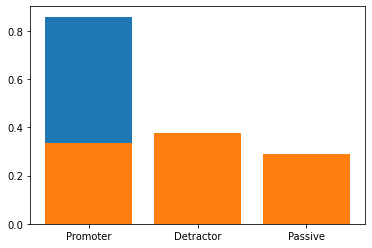

In [6]:
# We are in Territory 3, Market 21, District 125 - national cleanup takes about 10 minutes
# NPS_cleanup_market(21, 125)

# Since we can do national extracts it's easier just to process the entire file.
# Ideally we'd have all the stores mapped to their relevant Markets and Districts... <tbd>
# by convention I am putting raw files in ../data/raw and cleaned files in ../data/cleaned
import datetime

start = datetime.datetime.now()
print(f'Starting processing National NPS file at {start}')

NPS_cleanup_national('../data/raw/NPS_NATL_archive.xlsx', '../data/clean/NPS_Natl_cleaned.csv', 0)
#NPS_cleanup_national('../data/raw/export_Main Hierarchy_NTL.xlsx', '../data/clean/NPS_Natl_cleaned.csv')

end = datetime.datetime.now()

print(f'Total elapsed time was: {end - start}')
equalize_NPS_file('../data/clean/NPS_NATL_cleaned.csv', '../data/clean/NPS_NATL_subset.csv')


Starting processing National USO NPS file at 2022-06-14 13:56:49.416078
..Processing National NPS Surveys from ../data/raw/export_USO Hierarchy_NTL.xlsx
....Read 98513 comments from National file ../data/raw/export_USO Hierarchy_NTL.xlsx
There were 18292 Null Promoter comments.
Before drop: 98513
Dropped: 18292 null NPS comments
Done
Before equalization, Promoters: 72767, Passives: 3507, Detractors: 3947
After redistribution: Promoters: 3727, Passives: 3507, Detractors: 3947
Total elapsed time was: 0:02:27.023602


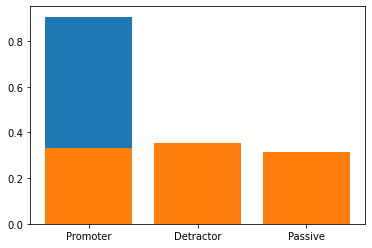

In [7]:
start = datetime.datetime.now()

print(f'Starting processing National USO NPS file at {datetime.datetime.now()}')
NPS_cleanup_uso('../data/raw/export_USO Hierarchy_NTL.xlsx', '../data/clean/NPS_USO_cleaned.csv', 6)
end = datetime.datetime.now()
print(f'Total elapsed time was: {end - start}')
equalize_NPS_file('../data/clean/NPS_USO_cleaned.csv', '../data/clean/NPS_USO_subset.csv')
